In [1]:
%%capture
%matplotlib inline

import numpy as np
import fipy as fp

import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
from matplotlib.animation import FuncAnimation
#from matplotlib import animation, rc
from IPython.display import HTML
print(fp.DefaultSolver)

Setup for the shallow water equations solution. $L_x$ is in the Debye lengths, $dt$ is in the reciprocal ion plasma friquency

In [2]:
Lx = 40.; dt = 0.05; steps = 100

Our mesh will span $[-L_x/2;L_x/2]$

In [3]:
mesh = fp.Grid1D(nx=300, Lx=Lx) - Lx/2.; x = mesh.x

Shallow water equations for expanding plasma take the form
\begin{equation}
\frac{\partial n}{dt} + \frac{1}{dx} (nv) = 0,
\end{equation}
\begin{equation}
\frac{\partial v}{dt} + v\frac{\partial v}{dx} = - T(t)\frac{\partial \ln(n)}{dx}
\end{equation}

In [4]:
n = fp.CellVariable(mesh=mesh, hasOld = True)
v = fp.CellVariable(mesh=mesh, hasOld = True)
T = fp.Variable(value = 1.)

In [5]:
cont_eq = fp.TransientTerm(var=n) == -fp.ConvectionTerm(coeff=v.faceValue*[[1.0]], var=n)
moti_eq = fp.TransientTerm(var=v) == -fp.ConvectionTerm(coeff=v.faceValue*[[0.5]], var=v) - T * n.grad[0]/n #T * (fp.numerix.log(n.faceValue)).divergence
eqn = cont_eq & moti_eq

Rougth boundary condition for $v$.

First test is analitical solution of one-way plasma to vacuum expansion. Initial condition is step in $n$.

In [6]:
t = dt

n.faceGrad.constrain(0.  , where=mesh.facesRight)
v.faceGrad.constrain(0.  , where=mesh.facesLeft)
v.faceGrad.constrain(0.  , where=mesh.facesRight)

v.setValue(0.)
v.setValue(x/t+1., where = x > 0.)
n.setValue(1.)
n.setValue(fp.numerix.exp(-x/t-1.), where = x > 0.)

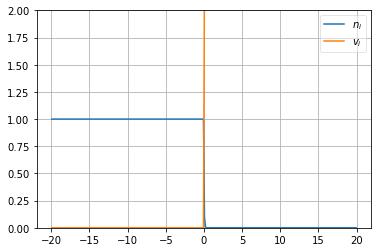

In [7]:
fig = plt.figure()
ax =  fig.add_subplot(111)
ax.set_ylim((0,2.))
x_plot = np.array(mesh.x)
p_n,      = ax.plot(x_plot, n.value, '-', label = '$n_i$')
p_v,      = ax.plot(x_plot, v.value, '-',label = '$v_i$')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=1, fancybox=True, framealpha=0.5)
ax.grid()
plt.show()
a_n,      = ax.plot(x_plot, n.value, '--', label = '$n_i^{an}$')
a_v,      = ax.plot(x_plot, v.value, '--',label = '$v_i^{an}$')

In [8]:
def update(i):
    #print i
    global t
    n.updateOld()
    v.updateOld()
    res = 1.
    while res > 0.001:
        res = eqn.sweep(dt=dt)
        #print res
    t = t + dt
    p_n.set_ydata(n.value)
    p_v.set_ydata(v.value)
    a_n.set_ydata(np.exp(-x/t-1.))
    a_v.set_ydata(x/t+1)

In [9]:
animation = FuncAnimation(fig, update, frames=steps, repeat=False)

In [10]:
animation

Next test is gaussian pellet. Now we start from $T=0$ in Eq. (2), so it needs more time to expand.